In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller
from datetime import datetime
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

# 1. Загрузка данных

In [316]:
total_df = pd.DataFrame(index = range(0), columns = ["Date"])

for file in [
    'B3.xlsx',
     'B4.xlsx',
     'B5.xlsx',
     'B6.xlsx',
     'B7.xlsx',
     'BRENT.xlsx',
     'INDICES.xlsx',
     'INTEREST_RATES.xlsx',
     'PESORUB.xlsx',
     'STOCKS.xlsx',
     'USDRUB.xlsx'
]:
    df_to_add = pd.read_excel(file)
    new_cols = list(df_to_add.columns)
    new_cols[0] = "Date"
    df_to_add.columns = new_cols
    total_df = pd.merge(total_df, df_to_add, how = "outer", on = "Date")

In [317]:
total_df = total_df.sort_values(by = "Date")

In [318]:
na_list = total_df.isna().sum(axis = 1)
rows_to_drop = na_list[na_list > 0].index

In [319]:
total_df = total_df.drop(rows_to_drop, axis = 0)

In [320]:
total_df.index = total_df["Date"]

In [321]:
cols_to_drop = [col for col in total_df.columns if "PRICE" in col]
total_df = total_df.drop(cols_to_drop, axis = 1)

### Перейдем от абсолютных значений к лог.доходностям

In [322]:
total_df_logret = total_df

for col in total_df.columns:
    if col != "Date":
        total_df_logret[col] = np.log(total_df_logret[col]).diff()

In [323]:
total_df_logret = total_df_logret.iloc[1:, :]

In [324]:
total_df_logret.isna().sum()

Date              0
B3_YTM            0
B4_YTM            0
B5_YTM            0
B6_YTM            0
B7_YTM            0
BRENT             0
MOEX RX Equity    0
RTSI$ Index       0
5                 0
7                 0
10                0
15                0
20                0
30                0
PESO              0
GAZP RX Equity    0
AFLT RX Equity    0
GMKN RX Equity    0
ALRS RX Equity    0
NVTK RX Equity    0
ROSN RX Equity    0
SBER RX Equity    0
NLMK RX Equity    0
YNDX RX Equity    0
URKA RX Equity    0
USD               0
dtype: int64

In [325]:
total_df_logret.head()

,Date,B3_YTM,B4_YTM,B5_YTM,B6_YTM,B7_YTM,BRENT,MOEX RX Equity,RTSI$ Index,5,...,AFLT RX Equity,GMKN RX Equity,ALRS RX Equity,NVTK RX Equity,ROSN RX Equity,SBER RX Equity,NLMK RX Equity,YNDX RX Equity,URKA RX Equity,USD
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,2016-01-05,-0.015456,-0.010352,-0.001017,-0.005141,0.007183,-0.017542,0.026324,0.004554,-0.006141,...,-0.031634,0.018105,0.045845,0.004543,0.008727,0.008939,-0.011945,0.063534,0.002852,0.002160
2016-01-06,2016-01-06,0.003110,0.013437,0.013138,0.007191,-0.013382,-0.077354,0.001484,-0.021323,0.011230,...,-0.007373,-0.010512,-0.001905,-0.009811,-0.003165,-0.020845,0.000000,-0.019503,0.013860,0.019349
2016-01-11,2016-01-11,0.059284,0.052012,0.031623,0.045030,0.050516,-0.105866,0.000635,-0.052507,0.049515,...,-0.037513,-0.044351,-0.027770,-0.031294,-0.046011,-0.061974,-0.023483,-0.119245,0.011173,0.019164
2016-01-12,2016-01-12,0.027900,0.016433,0.034420,0.032727,0.031040,-0.032925,-0.007968,-0.005465,0.010572,...,0.022601,-0.005480,0.038974,0.029532,-0.004782,0.007442,0.026114,0.012085,-0.012860,0.010882
2016-01-13,2016-01-13,0.000000,0.001916,-0.002824,-0.007605,-0.008633,-0.011573,-0.023200,-0.002405,0.005720,...,0.032335,0.007107,-0.012592,0.010177,-0.001251,-0.002292,0.002460,0.006983,0.001687,-0.004853


In [326]:
total_df_logret.head()

,Date,B3_YTM,B4_YTM,B5_YTM,B6_YTM,B7_YTM,BRENT,MOEX RX Equity,RTSI$ Index,5,...,AFLT RX Equity,GMKN RX Equity,ALRS RX Equity,NVTK RX Equity,ROSN RX Equity,SBER RX Equity,NLMK RX Equity,YNDX RX Equity,URKA RX Equity,USD
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,2016-01-05,-0.015456,-0.010352,-0.001017,-0.005141,0.007183,-0.017542,0.026324,0.004554,-0.006141,...,-0.031634,0.018105,0.045845,0.004543,0.008727,0.008939,-0.011945,0.063534,0.002852,0.002160
2016-01-06,2016-01-06,0.003110,0.013437,0.013138,0.007191,-0.013382,-0.077354,0.001484,-0.021323,0.011230,...,-0.007373,-0.010512,-0.001905,-0.009811,-0.003165,-0.020845,0.000000,-0.019503,0.013860,0.019349
2016-01-11,2016-01-11,0.059284,0.052012,0.031623,0.045030,0.050516,-0.105866,0.000635,-0.052507,0.049515,...,-0.037513,-0.044351,-0.027770,-0.031294,-0.046011,-0.061974,-0.023483,-0.119245,0.011173,0.019164
2016-01-12,2016-01-12,0.027900,0.016433,0.034420,0.032727,0.031040,-0.032925,-0.007968,-0.005465,0.010572,...,0.022601,-0.005480,0.038974,0.029532,-0.004782,0.007442,0.026114,0.012085,-0.012860,0.010882
2016-01-13,2016-01-13,0.000000,0.001916,-0.002824,-0.007605,-0.008633,-0.011573,-0.023200,-0.002405,0.005720,...,0.032335,0.007107,-0.012592,0.010177,-0.001251,-0.002292,0.002460,0.006983,0.001687,-0.004853


### Создадим таблицы для процентных ставок, валют и нефти, индексов и акций и остальных переменных

In [327]:
total_df_logret.columns

Index(['Date', 'B3_YTM', 'B4_YTM', 'B5_YTM', 'B6_YTM', 'B7_YTM', 'BRENT',
       'MOEX RX Equity', 'RTSI$ Index', '5', '7', '10', '15', '20', '30',
       'PESO', 'GAZP RX Equity', 'AFLT RX Equity', 'GMKN RX Equity',
       'ALRS RX Equity', 'NVTK RX Equity', 'ROSN RX Equity', 'SBER RX Equity',
       'NLMK RX Equity', 'YNDX RX Equity', 'URKA RX Equity', 'USD'],
      dtype='object')

In [328]:
interest_cols = [col for col in total_df_logret.columns if len(col) <=2]
cur_oil_cols = ["PESO", "USD", "BRENT"]
ind_cols = ['MOEX RX Equity', 'RTSI$ Index']

In [329]:
df_interest = total_df_logret[interest_cols]
df_cur_oil = total_df_logret[cur_oil_cols]
df_ind = total_df_logret[ind_cols]

# 2.1. Проверка на стационарность

In [330]:
instruments = [
    'B3_YTM', 'B4_YTM', 'B5_YTM', 'B6_YTM', 'B7_YTM',
    'PESO', 'GAZP RX Equity', 'AFLT RX Equity', 'GMKN RX Equity',
       'ALRS RX Equity', 'NVTK RX Equity', 'ROSN RX Equity', 'SBER RX Equity',
       'NLMK RX Equity', 'YNDX RX Equity', 'URKA RX Equity', 'USD'
]

instruments_logret = total_df_logret[instruments]

### Посмотрим на графики рядов 

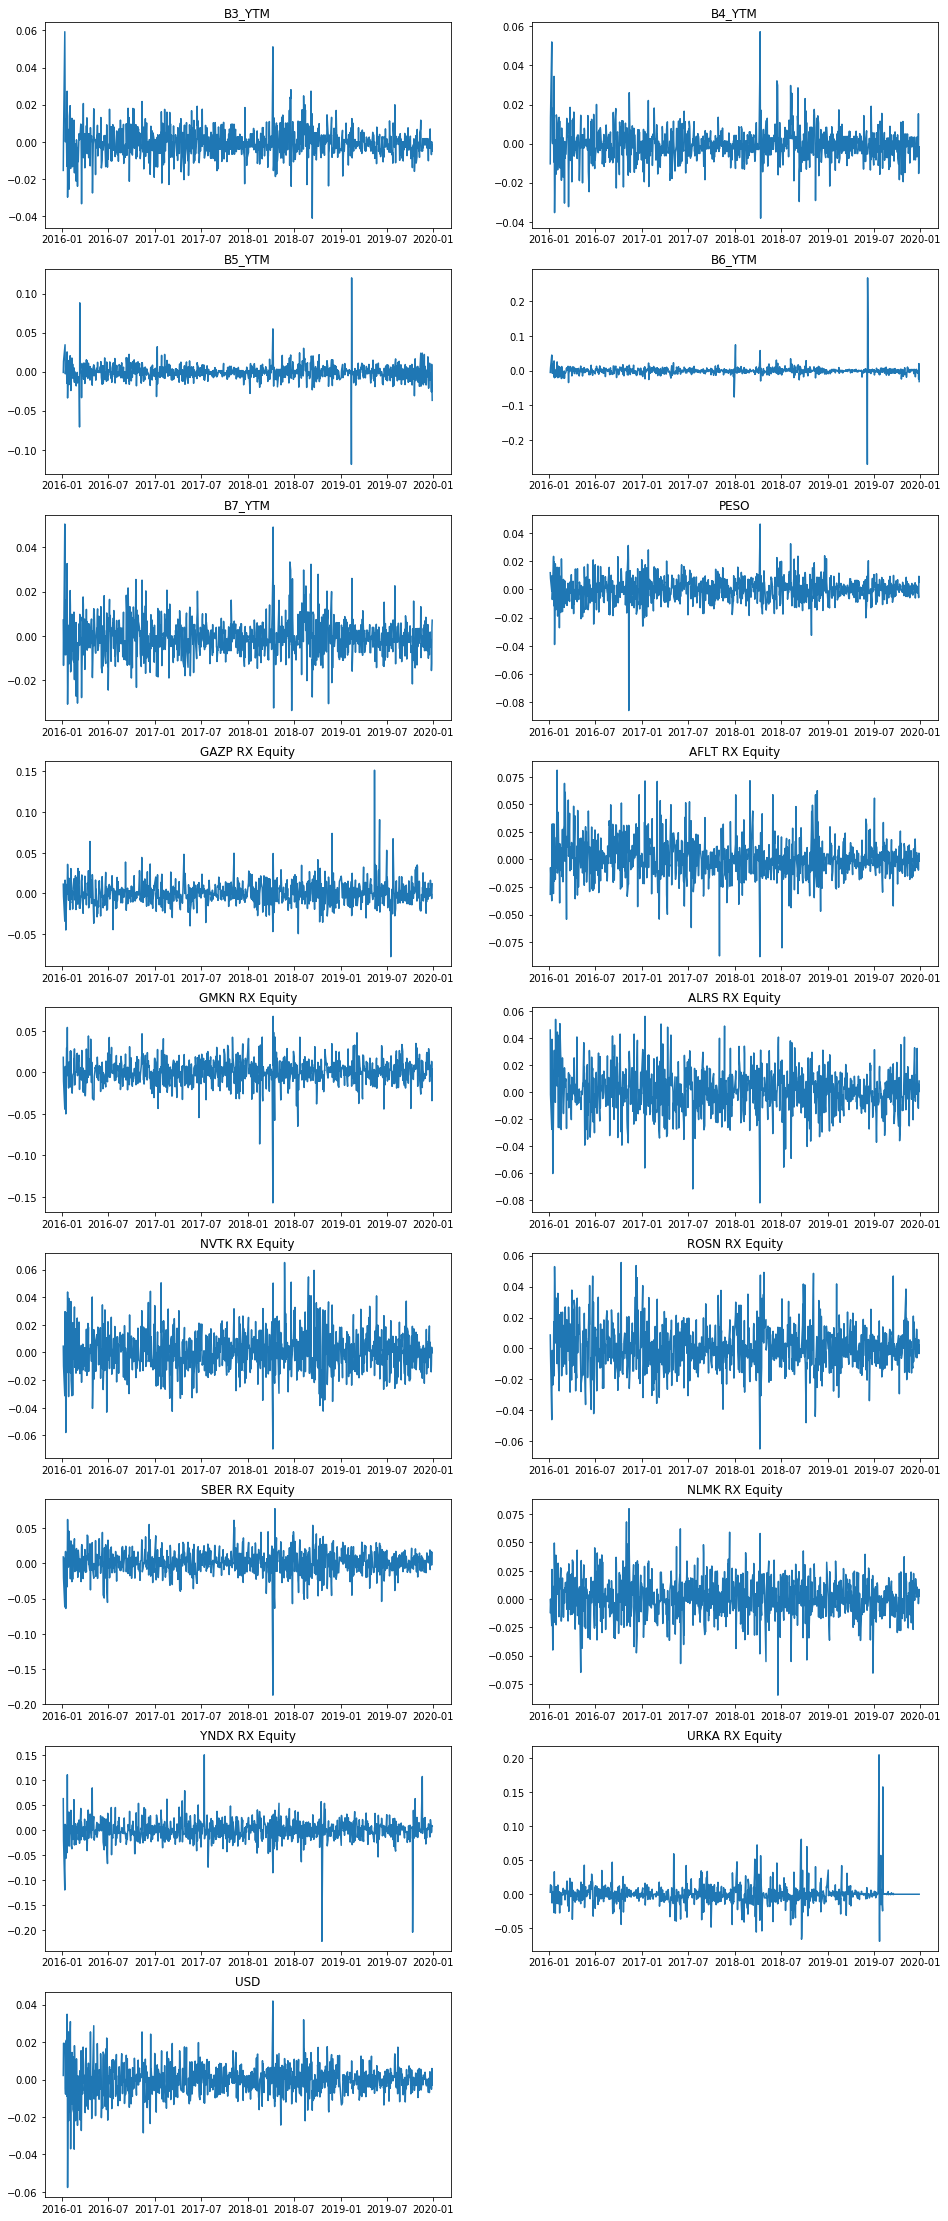

In [331]:
plt.figure(figsize = (16, 40))

for num, col in enumerate(instruments_logret.columns):
    plt.subplot(len(instruments_logret.columns) // 2 + 1, 2, num + 1)
    plt.plot(instruments_logret[col])
    plt.title(col)

### Судя по графикам, ряды плюс минус стационарные, но все же проведем тесты Дики Фуллера разных спецификаций, чтобы убедиться в отсутствии нестационарности

In [332]:
for col in df_interest.columns:
    for test in ["c", "ct", "ctt", "nc"]:
        if adfuller(df_interest[col], regression = test)[0] <\
        adfuller(df_interest[col], regression = test)[4]["5%"]:
            print(str(col) + ", " + test + ": stationary \n")
        else:
            print(str(col) + ", " + test + ": not stationary \n")
            

for col in df_ind.columns:
    for test in ["c", "ct", "ctt", "nc"]:
        if adfuller(df_ind[col], regression = test)[0] <\
        adfuller(df_ind[col], regression = test)[4]["5%"]:
            print(str(col) + ", " + test + ": stationary \n")
        else:
            print(str(col) + ", " + test + ": not stationary \n")


for col in df_cur_oil.columns:
    for test in ["c", "ct", "ctt", "nc"]:
        if adfuller(df_cur_oil[col], regression = test)[0] <\
        adfuller(df_cur_oil[col], regression = test)[4]["5%"]:
            print(str(col) + ", " + test + ": stationary \n")
        else:
            print(str(col) + ", " + test + ": not stationary \n")


for col in instruments_logret.columns:
    for test in ["c", "ct", "ctt", "nc"]:
        if adfuller(instruments_logret[col], regression = test)[0] <\
        adfuller(instruments_logret[col], regression = test)[4]["5%"]:
            print(str(col) + ", " + test + ": stationary \n")
        else:
            print(str(col) + ", " + test + ": not stationary \n")

5, c: stationary 

5, ct: stationary 

5, ctt: stationary 

5, nc: stationary 

7, c: stationary 

7, ct: stationary 

7, ctt: stationary 

7, nc: stationary 

10, c: stationary 

10, ct: stationary 

10, ctt: stationary 

10, nc: stationary 

15, c: stationary 

15, ct: stationary 

15, ctt: stationary 

15, nc: stationary 

20, c: stationary 

20, ct: stationary 

20, ctt: stationary 

20, nc: stationary 

30, c: stationary 

30, ct: stationary 

30, ctt: stationary 

30, nc: stationary 

MOEX RX Equity, c: stationary 

MOEX RX Equity, ct: stationary 

MOEX RX Equity, ctt: stationary 

MOEX RX Equity, nc: stationary 

RTSI$ Index, c: stationary 

RTSI$ Index, ct: stationary 

RTSI$ Index, ctt: stationary 

RTSI$ Index, nc: stationary 

PESO, c: stationary 

PESO, ct: stationary 

PESO, ctt: stationary 

PESO, nc: stationary 

USD, c: stationary 

USD, ct: stationary 

USD, ctt: stationary 

USD, nc: stationary 

BRENT, c: stationary 

BRENT, ct: stationary 

BRENT, ctt: stationary 



### Итак, все ряды лог.доходностей стационарны

# 2.2 Снижаем размерность пространства процентных ставок

### Нам необходимо снизить размерность пространства процентных ставок на сроки от 5 до 30 лет, потому что ставки сильно коррелируют

In [334]:
np.corrcoef(df_interest)

array([[ 1.        , -0.9275229 , -0.42546997, ...,  0.53959163,
         0.97275988, -0.97051379],
       [-0.9275229 ,  1.        ,  0.21352708, ..., -0.48063307,
        -0.82650888,  0.87875914],
       [-0.42546997,  0.21352708,  1.        , ...,  0.30434472,
        -0.48734445,  0.29507445],
       ...,
       [ 0.53959163, -0.48063307,  0.30434472, ...,  1.        ,
         0.52137015, -0.65027392],
       [ 0.97275988, -0.82650888, -0.48734445, ...,  0.52137015,
         1.        , -0.97271565],
       [-0.97051379,  0.87875914,  0.29507445, ..., -0.65027392,
        -0.97271565,  1.        ]])

In [335]:
for n in range(df_interest.shape[1]):
    dim_red = PCA(n_components = n + 1)
    dim_red.fit(df_interest)
    print(str(n + 1) + " component(s)" + "\n" + "explained variance: " +\
          str(np.sum(dim_red.explained_variance_ratio_)) + "\n")

1 component(s)
explained variance: 0.840858014249074

2 component(s)
explained variance: 0.979988860402272

3 component(s)
explained variance: 0.9946317217267087

4 component(s)
explained variance: 0.998086749566939

5 component(s)
explained variance: 0.9993206063602431

6 component(s)
explained variance: 0.9999999999999999



### Оставим две главные компоненты, так как это минимальное кол-во компонент, объясняюшее больше 90% вариации

In [336]:
PCA_interest = PCA(n_components=2)
df_interest = pd.DataFrame(PCA_interest.fit_transform(df_interest))

### Перейдем к симуляциям риск-факторов

# 3. Симуляции риск-факторов

### У нас есть три группы риск-факторов: главные компоненты пространства лог.доходностей процентных ставок, лог.доходности индексов, лог.доходности валют и нефти

### Для симуляций главных компонент лог.доходностей проценных ставок будем использовать модель Васичека.

### Для симуляции лог.доходностей индексов и лог.доходностей валют и нефти будем использовать random walk

## Генерация скоррелированных приращений

In [337]:
def generate_correlated_dWt(cor_matrix, steps_amount, dt):
    L = np.linalg.cholesky(cor_matrix)
    uncorrelated_dWt = np.random.normal(loc=0.0, scale=1.0, size=(cor_matrix.shape[0], steps_amount)) * np.sqrt(dt)
    return L.dot(uncorrelated_dWt)


## Симуляции процентных ставок

In [338]:
def vasicek_model(pred_param, current_value, dWt, dt):
    sigma, alpha, theta = pred_param #sigma-sigma alpha=k theta=r
    drift_coef = alpha * (theta - current_value)
    new_r = current_value + drift_coef * dt + sigma * dWt
    return new_r

def vasicek_estimation(data):
    dt = 1
    s0 = data[:-1].sum() / data.shape[0]
    s1 = data[1:].sum() / data.shape[0]
    s00 = (data[:-1] * data[:-1]).sum() / data.shape[0]
    s01 =  (data[1:] * data[:-1]).sum() / data.shape[0]
    r_opt = (s1 * s00 - s0*s01) / (s0*s1 - s0 ** 2 -s01 + s00)
    k = (1 / dt)*np.log((s0 - r_opt) / (s1 - r_opt))
    #k = (-1 / dt)*np.log((s01 - r_opt*s0 - r_opt*s1 + data.shape[0]*r_opt**2) / (s00 - 2*r_opt*s0 + data.shape[0]*r_opt**2))
    beta = (1/k) * (1 - np.exp(-k * dt))
    m = r_opt * k * beta + data[:-1] * (1 - k*beta)
    sigma_square = (1 / (data.shape[0] * beta*(1 - 0.5*k*beta))) * ((data[1:] - m) ** 2).sum()
    return sigma_square, k, r_opt

def get_vasicek_pred(current_value, pred_param, dWt, dt):
    '''if steps_amount == 1:
        dWt = generate_correlated_dWt(cor_matrix, dt)
        new_value = vasicek_model(pred_param, current_value, dWt, dt)
        return new_value
    
    return get_vasicek_pred(new_value, pred_param, cor_matrix, steps_amount - 1, dt)'''
    
    #preds = [current_value]
    preds = []
    #preds = 
    for cur_dwt in dWt:
        cur_dt = 1
        #dWt = np.random.normal(0, 1)
        current_value = vasicek_model(pred_param, current_value, cur_dwt, cur_dt)
        preds.append(current_value)
    return preds


In [339]:
def simulate_interest(day_n, time_horizon):
    n_factors = df_interest.shape[1]
    n_days = time_horizon
    n_sims = 200

    sims_interest = np.zeros((n_factors, n_sims, n_days))

    init_vals = df_interest.values[day_n, :]
    cor_matrix = np.corrcoef(df_interest.T)

    for factor in range(n_factors):
        init_val = init_vals[factor]
        params = vasicek_estimation(df_interest.values[:, factor])
        sim = 0
        for sim in range(n_sims):
            dwt = generate_correlated_dWt(cor_matrix, n_days, 1)[factor]
            sims_interest[factor][sim] = get_vasicek_pred(init_val, params, dwt, 1)
            
    return sims_interest

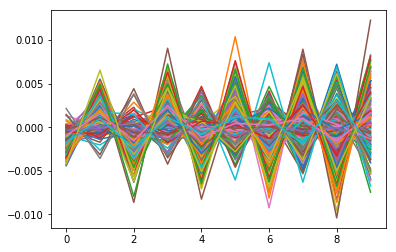

In [340]:
plt.plot(simulate_interest(0, 10)[0].T)

## Симуляции индексов, валютных курсов и цен на нефть

In [434]:
def gbm_estimation(data):
    mu = np.mean(data)
    sigma_square = (-1 + np.sqrt(1 + ((data - mu) ** 2).sum() / data.shape[0])) / 0.5
    return mu, sigma_square

def gbm_model(pred_param, current_value, dWt, dt):
    mu, sigma_square = pred_param #sigma-sigma alpha=k theta=r
    drift_coef = mu - 0.5 * sigma_square
    new_r = current_value + drift_coef * dt + np.sqrt(sigma_square) * dWt
    return new_r

def get_gbm_pred(current_value, pred_param, dWt):
    #preds = [current_value]
    preds = []
    for cur_dwt in dWt:
        cur_dt = 1
        #dWt = np.random.normal(0, 1)
        current_value = gbm_model(pred_param, current_value, cur_dwt, cur_dt)
        preds.append(current_value)
    return preds


### Индексы

In [382]:
def simulate_indices(day_n, time_horizon):
    n_factors = df_ind.shape[1]
    n_days = time_horizon
    n_sims = 200

    sims_ind = np.zeros((n_factors, n_sims, n_days))

    init_vals = df_ind.values[day_n, :]
    cor_matrix = np.corrcoef(df_ind.T)

    for factor in range(n_factors):
        init_val = init_vals[factor]
        params = gbm_estimation(df_ind.values[:, factor])
        sim = 0
        for sim in range(n_sims):
            dwt = generate_correlated_dWt(cor_matrix, n_days, 1)[factor]
            sims_ind[factor][sim] = get_gbm_pred(init_val, params, dwt)
            
    return sims_ind

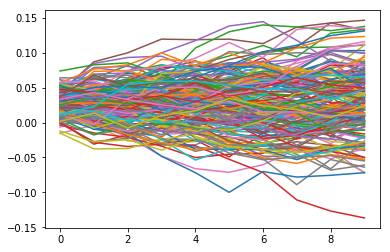

In [383]:
plt.plot(simulate_indices(0, 10)[0].T)

### Валюты и нефть

In [344]:
def simulate_cur_oil(day_n, time_horizon):
    n_factors = df_cur_oil.shape[1]
    n_days = time_horizon
    n_sims = 200

    sims_cur_oil = np.zeros((n_factors, n_sims, n_days))

    init_vals = df_cur_oil.values[day_n, :]
    cor_matrix = np.corrcoef(df_cur_oil.T)

    for factor in range(n_factors):
        init_val = init_vals[factor]
        params = gbm_estimation(df_cur_oil.values[:, factor])
        sim = 0
        for sim in range(n_sims):
            dwt = generate_correlated_dWt(cor_matrix, n_days, 1)[factor]
            sims_cur_oil[factor][sim] = get_gbm_pred(init_val, params, dwt)
            
    return sims_cur_oil

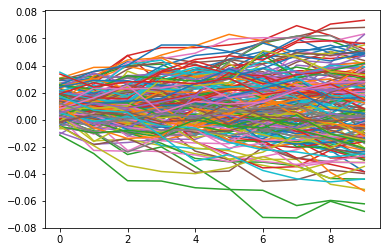

In [345]:
plt.plot(simulate_cur_oil(0, 10)[0].T)

# 4. Оценка стоимости портфеля

## 4.1. Оценка стоимости каждого инструмента

In [346]:
total_df = pd.DataFrame(index = range(0), columns = ["Date"])

for file in [
    'B3.xlsx',
     'B4.xlsx',
     'B5.xlsx',
     'B6.xlsx',
     'B7.xlsx',
     'BRENT.xlsx',
     'INDICES.xlsx',
     'INTEREST_RATES.xlsx',
     'PESORUB.xlsx',
     'STOCKS.xlsx',
     'USDRUB.xlsx'
]:
    df_to_add = pd.read_excel(file)
    new_cols = list(df_to_add.columns)
    new_cols[0] = "Date"
    df_to_add.columns = new_cols
    total_df = pd.merge(total_df, df_to_add, how = "outer", on = "Date")

total_df = total_df.sort_values(by = "Date")

na_list = total_df.isna().sum(axis = 1)
rows_to_drop = na_list[na_list > 0].index

total_df = total_df.drop(rows_to_drop, axis = 0)

total_df.index = total_df["Date"]

cols_to_drop = [col for col in total_df.columns if "PRICE" in col]
total_df = total_df.drop(cols_to_drop, axis = 1)

In [347]:
all_bonds = [i for i in instruments if "YTM" in i]
all_stocks = [i for i in instruments if "Equity" in i]
all_curr = ["PESO", "USD"]

In [348]:
df_bonds = total_df[all_bonds][1:]
df_stocks = total_df[all_stocks][1:]
df_curr = total_df[all_curr][1:]

### Стоимость инструментов будем оценивать следующим образом: сначала оценим лин.регрессию логюдоходности инструмента на риск-факторы, затем получим предсказания логюдоходностей инструмента, а после этого узнаем стоимость инструмента на основе предыдущих стоимостей и предсказанной лог.доходности

### В случае облигаций алгоритм несколько иной: оценим лин.регрессию лог.доходностей YTM на риск-факторы, затем получим предсказания лог. доходностей YTM, а после этого подставим предсказания YTM в формулу стоимости облигации, соответствующую сумме дисконтированных денежных потоков, где YTM - ставка дисконтирования.

### 1.1 Облигации

In [384]:
def days_diff(date1, date2):
    date1 = datetime.strptime(date1, "%d.%m.%Y")
    date2 = datetime.strptime(date2, "%d.%m.%Y")
    return abs((date2 - date1).days)

In [385]:
class Bond:
    def __init__(self, coupon = None, maturity_date = None, FV = None):
        self.coupon = coupon
        self.maturity_date = maturity_date
        self.FV = FV
        self.schedule = []
        self.accr_interest = None
        self.clean_price = None
        
    def correct_date(self, date):
        if datetime.strptime(str(date), "%d.%m.%Y").weekday() == 5:
            if (datetime.strptime(str(date), "%d.%m.%Y") + timedelta(2)).month ==\
            int(date.split(".")[1]):
                date = datetime.strftime(datetime.strptime(str(date), "%d.%m.%Y") +\
                                                       timedelta(2), "%d.%m.%Y")
            else:
                date = datetime.strftime(datetime.strptime(str(date), "%d.%m.%Y") -\
                                               timedelta(1),\
                                               "%d.%m.%Y")
        elif datetime.strptime(str(date), "%d.%m.%Y").weekday() == 6:
            if (datetime.strptime(str(date), "%d.%m.%Y") + timedelta(1)).month ==\
                int(date.split(".")[1]):
                date = datetime.strftime(datetime.strptime(str(date), "%d.%m.%Y") +\
                                                       timedelta(1), "%d.%m.%Y")
            else:
                date = datetime.strftime(datetime.strptime(str(date), "%d.%m.%Y") -\
                                               timedelta(2), "%d.%m.%Y")
        return date
    
    def calculate_schedule(self):
        latest_date = self.correct_date(self.maturity_date)
        days_bw_pay = 182
        schedule = [latest_date]
        while min(datetime.strptime("01.01.2016", "%d.%m.%Y"), datetime.strptime(latest_date, "%d.%m.%Y"))\
            == datetime.strptime("01.01.2016", "%d.%m.%Y") and latest_date != "01.01.2016":
            latest_date = datetime.strptime(latest_date, "%d.%m.%Y")
            latest_date -= timedelta(days_bw_pay)
            latest_date = datetime.strftime(latest_date, "%d.%m.%Y")
            latest_date = self.correct_date(latest_date)
            schedule.append(latest_date)
        return schedule[::-1]
        
    def calculate_accrued_interest(self, date):
        self.schedule = self.calculate_schedule()
        previous_payments = [i for i in self.schedule if
                            min(datetime.strptime(date, "%d.%m.%Y"), datetime.strptime(i, "%d.%m.%Y"))
                            == datetime.strptime(i, "%d.%m.%Y")]
        previous_payment = previous_payments[-1]
        days_since_last_payment = days_diff(date, previous_payment)
        accr_interest = self.FV * self.coupon / 100\
            * days_since_last_payment / 365
        return accr_interest
    
    def calculate_clean_price(self, date, ytm):
        self.accr_interest = self.calculate_accrued_interest(date)
        future_payments = [i for i in self.schedule if
                            max(datetime.strptime(date, "%d.%m.%Y"), datetime.strptime(i, "%d.%m.%Y"))
                            == datetime.strptime(i, "%d.%m.%Y")]
        dirty_price = self.FV * np.exp(- ytm / 100 * days_diff(date, future_payments[-1]) / 365)
        for payment in future_payments:
            days_till_coupon = days_diff(date, payment)
            dirty_price += self.coupon / 2 / 100 * self.FV * np.exp(- ytm / 100 * days_till_coupon / 365)
        self.clean_price = dirty_price - self.accr_interest
        return self.clean_price

In [413]:
def price_bond(bond, day_n, time_horizon):
    coupon, maturity_date, FV, ticker = bond
    bond = df_bonds[ticker]
    base_price = bond[day_n - 1]
    date = datetime.strftime(df_bonds.index[day_n+time_horizon-1], "%d.%m.%Y")
    lin_reg = LinearRegression()
    lin_reg.fit(df_interest[:-1], instruments_logret[ticker][1:])
    sims = simulate_interest(day_n - 1, time_horizon)
    
    nSim = 200
    
    daily_ret = np.zeros((nSim, time_horizon))
    cumul_ret = np.zeros((nSim, time_horizon))
    ytm = np.zeros(nSim)
     
    my_bond = Bond(coupon, maturity_date, FV)
        
    for sim in range(nSim):
        for t in range(time_horizon):
            daily_ret[sim][t] = lin_reg.predict(sims[:, sim, t].reshape(1, -1))
            cumul_ret[sim][t] = np.sum(daily_ret[sim][:t+1])
    
    return my_bond.calculate_clean_price(date, base_price * np.exp(cumul_ret[:, time_horizon-1]))

In [387]:
b3 = (7.6, "20.07.2022", 1000, "B3_YTM")
b4 = (7, "16.08.2023", 1000, "B4_YTM")
b5 = (6.4, "27.05.2020", 1000, "B5_YTM")
b6 = (7.6, "14.04.2021", 1000, "B6_YTM")
b7 = (7, "25.01.2023", 1000, "B7_YTM")

### 1.2 Акции

In [414]:
def price_stock(stock, day_n, time_horizon):
    ticker = stock
    stock = df_stocks[ticker]
    base_price = stock[day_n - 1]
    lin_reg = LinearRegression()
    lin_reg.fit(df_ind[:-1], instruments_logret[ticker][1:])
    sims = simulate_indices(day_n - 1, time_horizon)
    
    nSim = 200
    
    daily_ret = np.zeros((nSim, time_horizon))
    cumul_ret = np.zeros((nSim, time_horizon))
    
    for sim in range(nSim):
        for t in range(time_horizon):
            daily_ret[sim][t] = lin_reg.predict(sims[:, sim, t].reshape(1, -1))
            cumul_ret[sim][t] = np.sum(daily_ret[sim][:t+1])
    
    return base_price * np.exp(cumul_ret[:, time_horizon-1])

### 1.3 Валюты

In [415]:
def price_curr(curr, day_n, time_horizon):
    ticker = curr
    curr = df_curr[ticker]
    base_price = curr[day_n - 1]
    lin_reg = LinearRegression()
    lin_reg.fit(df_cur_oil[:-1], instruments_logret[ticker][1:])
    sims = simulate_cur_oil(day_n - 1, time_horizon)
    
    nSim = 200
    
    daily_ret = np.zeros((nSim, time_horizon))
    cumul_ret = np.zeros((nSim, time_horizon))
    
    for sim in range(nSim):
        for t in range(time_horizon):
            daily_ret[sim][t] = lin_reg.predict(sims[:, sim, t].reshape(1, -1))
            cumul_ret[sim][t] = np.sum(daily_ret[sim][:t+1])
    
    return base_price * np.exp(cumul_ret[:, time_horizon-1])

## 2. Перебалансировка портфеля

In [416]:
position_0 = np.array([10e6] * 5 + [1e6] * 10 + [10e6] * 2)

In [417]:
price = np.array([
    Bond(b3[0],b3[1],b3[2]).calculate_clean_price(datetime.strftime(df_bonds.index[0], "%d.%m.%Y"), df_bonds.iloc[0, 0]),
    Bond(b4[0],b4[1],b4[2]).calculate_clean_price(datetime.strftime(df_bonds.index[0], "%d.%m.%Y"), df_bonds.iloc[0, 1]),
    Bond(b5[0],b5[1],b5[2]).calculate_clean_price(datetime.strftime(df_bonds.index[0], "%d.%m.%Y"), df_bonds.iloc[0, 2]),
    Bond(b6[0],b6[1],b6[2]).calculate_clean_price(datetime.strftime(df_bonds.index[0], "%d.%m.%Y"), df_bonds.iloc[0, 3]),
    Bond(b7[0],b7[1],b7[2]).calculate_clean_price(datetime.strftime(df_bonds.index[0], "%d.%m.%Y"), df_bonds.iloc[0, 4]),
] + list(df_stocks.values[0, :]) + list(df_curr.values[0, :]))

In [418]:
qty = position_0 / price
qty

array([1.11898946e+04, 1.17513364e+04, 1.14605186e+04, 1.10326251e+04,
       1.17572217e+04, 7.32869183e+03, 1.83654729e+04, 1.10071547e+02,
       1.73010381e+04, 1.74337517e+03, 3.94944708e+03, 1.01122459e+04,
       1.64609053e+04, 8.81911985e+02, 5.69638280e+03, 2.36283730e+06,
       1.36375414e+05])

In [419]:
all_qty = qty
all_price = price

In [420]:
wts_0 = position_0 / np.sum(position_0)
wts_0

array([0.125 , 0.125 , 0.125 , 0.125 , 0.125 , 0.0125, 0.0125, 0.0125,
       0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.0125, 0.125 ,
       0.125 ])

In [421]:
for t in range(1, instruments_logret.shape[0]):
    price = np.array([
    Bond(b3[0],b3[1],b3[2]).calculate_clean_price(datetime.strftime(df_bonds.index[t], "%d.%m.%Y"), df_bonds.iloc[t, 0]),
    Bond(b4[0],b4[1],b4[2]).calculate_clean_price(datetime.strftime(df_bonds.index[t], "%d.%m.%Y"), df_bonds.iloc[t, 1]),
    Bond(b5[0],b5[1],b5[2]).calculate_clean_price(datetime.strftime(df_bonds.index[t], "%d.%m.%Y"), df_bonds.iloc[t, 2]),
    Bond(b6[0],b6[1],b6[2]).calculate_clean_price(datetime.strftime(df_bonds.index[t], "%d.%m.%Y"), df_bonds.iloc[t, 3]),
    Bond(b7[0],b7[1],b7[2]).calculate_clean_price(datetime.strftime(df_bonds.index[t], "%d.%m.%Y"), df_bonds.iloc[t, 4])
    ] + list(df_stocks.values[t, :]) + list(df_curr.values[t, :]))
    wts = (qty * price) / np.sum(qty * price)
    delta_wts = wts_0 / wts
    qty = qty * delta_wts
    all_qty = np.vstack((all_qty, qty))
    all_price = np.vstack((all_price, price))

# 4.2. Вычисление метрик рыночного риска

### 4.2.1 Горизонт - 1 день

### Облигации

In [435]:
bond_prices = np.zeros((instruments_logret.shape[0]-1, 200, 5))

for t in range(1, instruments_logret.shape[0]):
    for num, bond in enumerate([b3, b4, b5, b6, b7]):
        bond_prices[t-1, :, num] = (price_bond(bond=bond, day_n=t, time_horizon=1) - all_price[t-1, num]) * all_qty[t, num] 
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

254th period price is calculated
255th period price is calculated
256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th peri

504th period price is calculated
505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th period price is calculated
534th peri

753th period price is calculated
754th period price is calculated
755th period price is calculated
756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th period price is calculated
783th peri

In [436]:
total_1d_bond_prices = np.zeros((instruments_logret.shape[0]-1, 200))

for t in range(instruments_logret.shape[0]-1):
    for sim in range(200):
        total_1d_bond_prices[t, sim] = np.sum(bond_prices[t, sim, :])

### Акции

In [437]:
stock_prices = np.zeros((instruments_logret.shape[0]-1, 200, 10))

for t in range(1, instruments_logret.shape[0]):
    for num, stock in enumerate(df_stocks.columns):
        stock_prices[t-1, :, num] = (price_stock(stock=stock, day_n=t, time_horizon=1) - all_price[t-1, num+5]) * all_qty[t, num+5]
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

254th period price is calculated
255th period price is calculated
256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th peri

503th period price is calculated
504th period price is calculated
505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th peri

752th period price is calculated
753th period price is calculated
754th period price is calculated
755th period price is calculated
756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th peri

In [438]:
total_1d_stock_prices = np.zeros((instruments_logret.shape[0]-1, 200))

for t in range(instruments_logret.shape[0]-1):
    for sim in range(200):
        total_1d_stock_prices[t, sim] = np.sum(stock_prices[t, sim, :])

### Валюты

In [439]:
curr_prices = np.zeros((instruments_logret.shape[0]-1, 200, 2))

for t in range(1, instruments_logret.shape[0]):
    for num, curr in enumerate(df_curr.columns):
        curr_prices[t-1, :, num] = (price_curr(curr=curr, day_n=t, time_horizon=1) - all_price[t-1, num+15]) * all_qty[t, num+15]
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th period price is calculated
285th period price is calculated
286th peri

505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th period price is calculated
534th period price is calculated
535th peri

756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th period price is calculated
783th period price is calculated
784th period price is calculated
785th period price is calculated
786th peri

In [440]:
total_1d_curr_prices = np.zeros((instruments_logret.shape[0]-1, 200))

for t in range(instruments_logret.shape[0]-1):
    for sim in range(200):
        total_1d_curr_prices[t, sim] = np.sum(curr_prices[t, sim, :])

### Суммируем все компоненты портфеля

In [441]:
total_1d_portfolio = total_1d_bond_prices +\
    total_1d_stock_prices + total_1d_curr_prices

## Расчет VaR

### VaR всего портфеля

In [528]:
VaR_1d_95 = - np.quantile(total_1d_portfolio, 0.05, 1)

### VaR облигаций

In [529]:
VaR_1d_95_bonds = - np.quantile(total_1d_bond_prices, 0.05, 1)

### VaR акций

In [530]:
VaR_1d_95_stocks = - np.quantile(total_1d_stock_prices, 0.05, 1)

### VaR валют

In [531]:
VaR_1d_95_curr = - np.quantile(total_1d_curr_prices, 0.05, 1)

## Расчет ES

### ES всего портфеля

In [532]:
ES_1d_97_5 = np.zeros(total_1d_portfolio.shape[0])

In [533]:
VaR_1d_97_5 = - np.quantile(total_1d_portfolio, 0.025, 1)

In [534]:
for num, val in enumerate(total_1d_portfolio):
    ES_1d_97_5[num] = - np.mean(val[val < - VaR_1d_97_5[num]])

### ES облигаций

In [535]:
ES_1d_97_5_bonds = np.zeros(total_1d_bond_prices.shape[0])

VaR_1d_97_5_bonds = - np.quantile(total_1d_bond_prices, 0.025, 1)

for num, val in enumerate(total_1d_bond_prices):
    ES_1d_97_5_bonds[num] = - np.mean(val[val < - VaR_1d_97_5_bonds[num]])

### ES акций

In [536]:
ES_1d_97_5_stocks = np.zeros(total_1d_stock_prices.shape[0])

VaR_1d_97_5_stocks = - np.quantile(total_1d_stock_prices, 0.025, 1)

for num, val in enumerate(total_1d_stock_prices):
    ES_1d_97_5_stocks[num] = - np.mean(val[val < - VaR_1d_97_5_stocks[num]])

### ES валют

In [537]:
ES_1d_97_5_curr = np.zeros(total_1d_curr_prices.shape[0])

VaR_1d_97_5_curr = - np.quantile(total_1d_curr_prices, 0.025, 1)

for num, val in enumerate(total_1d_curr_prices):
    ES_1d_97_5_curr[num] = - np.mean(val[val < - VaR_1d_97_5_curr[num]])

### 4.2.2 Горизонт - 10 дней

### Облигации

In [477]:
bond_prices_10d = np.zeros((instruments_logret.shape[0]-1-9, 200, 5))

for t in range(1, instruments_logret.shape[0] - 9):
    for num, bond in enumerate([b3, b4, b5, b6, b7]):
        bond_prices_10d[t-1, :, num] = (price_bond(bond=bond, day_n=t, time_horizon=10) - all_price[t-1, num]) * all_qty[t, num] 
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

254th period price is calculated
255th period price is calculated
256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th peri

503th period price is calculated
504th period price is calculated
505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th peri

752th period price is calculated
753th period price is calculated
754th period price is calculated
755th period price is calculated
756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th peri

In [478]:
total_10d_bond_prices = np.zeros((instruments_logret.shape[0]-1-9, 200))

for t in range(instruments_logret.shape[0]-1-9):
    for sim in range(200):
        total_10d_bond_prices[t, sim] = np.sum(bond_prices_10d[t, sim, :])

### Акции

In [479]:
stock_prices_10d = np.zeros((instruments_logret.shape[0]-1-9, 200, 10))

for t in range(1, instruments_logret.shape[0]-9):
    for num, stock in enumerate(df_stocks.columns):
        stock_prices_10d[t-1, :, num] = (price_stock(stock=stock, day_n=t, time_horizon=10) - all_price[t-1, num+5]) * all_qty[t, num+5]
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

254th period price is calculated
255th period price is calculated
256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th peri

503th period price is calculated
504th period price is calculated
505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th peri

752th period price is calculated
753th period price is calculated
754th period price is calculated
755th period price is calculated
756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th peri

In [480]:
total_10d_stock_prices = np.zeros((instruments_logret.shape[0]-1-9, 200))

for t in range(instruments_logret.shape[0]-1-9):
    for sim in range(200):
        total_10d_stock_prices[t, sim] = np.sum(stock_prices_10d[t, sim, :])

### Валюты

In [481]:
curr_prices_10d = np.zeros((instruments_logret.shape[0]-1-9, 200, 2))

for t in range(1, instruments_logret.shape[0]-9):
    for num, curr in enumerate(df_curr.columns):
        curr_prices_10d[t-1, :, num] = (price_curr(curr=curr, day_n=t, time_horizon=10) - all_price[t-1, num+15]) * all_qty[t, num+15]
    print(str(t+1) + "th period price is calculated")

2th period price is calculated
3th period price is calculated
4th period price is calculated
5th period price is calculated
6th period price is calculated
7th period price is calculated
8th period price is calculated
9th period price is calculated
10th period price is calculated
11th period price is calculated
12th period price is calculated
13th period price is calculated
14th period price is calculated
15th period price is calculated
16th period price is calculated
17th period price is calculated
18th period price is calculated
19th period price is calculated
20th period price is calculated
21th period price is calculated
22th period price is calculated
23th period price is calculated
24th period price is calculated
25th period price is calculated
26th period price is calculated
27th period price is calculated
28th period price is calculated
29th period price is calculated
30th period price is calculated
31th period price is calculated
32th period price is calculated
33th period pric

254th period price is calculated
255th period price is calculated
256th period price is calculated
257th period price is calculated
258th period price is calculated
259th period price is calculated
260th period price is calculated
261th period price is calculated
262th period price is calculated
263th period price is calculated
264th period price is calculated
265th period price is calculated
266th period price is calculated
267th period price is calculated
268th period price is calculated
269th period price is calculated
270th period price is calculated
271th period price is calculated
272th period price is calculated
273th period price is calculated
274th period price is calculated
275th period price is calculated
276th period price is calculated
277th period price is calculated
278th period price is calculated
279th period price is calculated
280th period price is calculated
281th period price is calculated
282th period price is calculated
283th period price is calculated
284th peri

503th period price is calculated
504th period price is calculated
505th period price is calculated
506th period price is calculated
507th period price is calculated
508th period price is calculated
509th period price is calculated
510th period price is calculated
511th period price is calculated
512th period price is calculated
513th period price is calculated
514th period price is calculated
515th period price is calculated
516th period price is calculated
517th period price is calculated
518th period price is calculated
519th period price is calculated
520th period price is calculated
521th period price is calculated
522th period price is calculated
523th period price is calculated
524th period price is calculated
525th period price is calculated
526th period price is calculated
527th period price is calculated
528th period price is calculated
529th period price is calculated
530th period price is calculated
531th period price is calculated
532th period price is calculated
533th peri

752th period price is calculated
753th period price is calculated
754th period price is calculated
755th period price is calculated
756th period price is calculated
757th period price is calculated
758th period price is calculated
759th period price is calculated
760th period price is calculated
761th period price is calculated
762th period price is calculated
763th period price is calculated
764th period price is calculated
765th period price is calculated
766th period price is calculated
767th period price is calculated
768th period price is calculated
769th period price is calculated
770th period price is calculated
771th period price is calculated
772th period price is calculated
773th period price is calculated
774th period price is calculated
775th period price is calculated
776th period price is calculated
777th period price is calculated
778th period price is calculated
779th period price is calculated
780th period price is calculated
781th period price is calculated
782th peri

In [482]:
total_10d_curr_prices = np.zeros((instruments_logret.shape[0]-1-9, 200))

for t in range(instruments_logret.shape[0]-1-9):
    for sim in range(200):
        total_10d_curr_prices[t, sim] = np.sum(curr_prices_10d[t, sim, :])

### Суммируем компоненты портфеля

In [483]:
total_10d_portfolio = total_10d_bond_prices +\
    total_10d_stock_prices + total_10d_curr_prices

## Расчет VaR

### VaR всего портфеля

In [538]:
VaR_10d_95 = - np.quantile(total_10d_portfolio, 0.05, 1)

### VaR облигаций

In [539]:
VaR_10d_95_bonds = - np.quantile(total_10d_bond_prices, 0.05, 1)

### VaR акций

In [540]:
VaR_10d_95_stocks = - np.quantile(total_10d_stock_prices, 0.05, 1)

### VaR валют

In [541]:
VaR_10d_95_curr = - np.quantile(total_10d_curr_prices, 0.05, 1)

## Расчет ES

### ES всего портфеля

In [542]:
ES_10d_97_5 = np.zeros(total_10d_portfolio.shape[0])

In [543]:
VaR_10d_97_5 = - np.quantile(total_10d_portfolio, 0.025, 1)

In [544]:
for num, val in enumerate(total_10d_portfolio):
    ES_10d_97_5[num] = - np.mean(val[val < - VaR_10d_97_5[num]])

### ES облигаций

In [546]:
ES_10d_97_5_bonds = np.zeros(total_10d_bond_prices.shape[0])

VaR_10d_97_5_bonds = - np.quantile(total_10d_bond_prices, 0.025, 1)

for num, val in enumerate(total_10d_bond_prices):
    ES_10d_97_5_bonds[num] = - np.mean(val[val < - VaR_10d_97_5_bonds[num]])

### ES акций

In [547]:
ES_10d_97_5_stocks = np.zeros(total_10d_stock_prices.shape[0])

VaR_10d_97_5_stocks = - np.quantile(total_10d_stock_prices, 0.025, 1)

for num, val in enumerate(total_10d_stock_prices):
    ES_1d_97_5_stocks[num] = - np.mean(val[val < - VaR_10d_97_5_stocks[num]])

### ES валют

In [548]:
ES_10d_97_5_curr = np.zeros(total_10d_curr_prices.shape[0])

VaR_10d_97_5_curr = - np.quantile(total_10d_curr_prices, 0.025, 1)

for num, val in enumerate(total_10d_curr_prices):
    ES_10d_97_5_curr[num] = - np.mean(val[val < - VaR_10d_97_5_curr[num]])

In [ ]:
pd.DataFrame(all_price).to_csv('RM_ALL_PRICES.csv', index = False)

pd.DataFrame(all_qty).to_csv('RM_ALL_QTY.csv', index = False)

In [ ]:
pd.DataFrame(total_10d_portfolio).to_csv('RM_TOTAL_10D_PORTFOLIO.csv', index = False)

pd.DataFrame(total_1d_portfolio).to_csv('RM_TOTAL_1D_PORTFOLIO.csv', index = False)

In [ ]:
pd.DataFrame(VaR_1d_95).to_csv("RM_VAR1D_95.csv", index = False)

pd.DataFrame(VaR_10d_95).to_csv("RM_VAR10D_95.csv", index = False)

pd.DataFrame(ES_1d_97_5).to_csv("RM_ES1D_975.csv", index = False)

pd.DataFrame(ES_10d_97_5).to_csv("RM_ES10D_975.csv", index = False)


# Бэктестинг

### Протестируем модели на корректность предсказаний

### Нулевая гипотеза: предсказания метрик рыночного риска корректные

$\mu$ - доля дней, когда предсказанное значение метрики рыночного риска было пробито

$\alpha$ - уровень значимости и доля пробитий при корректной модели (например, для VaR 95% $\alpha=0.05$)

$N$ - длина ряда

Тестовая статистика: $\frac{\mu - \alpha}{\sqrt{\mu(1-\mu)/N}}$

### 1-day VaR всего портфеля

In [549]:
all_gains_losses = np.diff(np.sum(all_qty * all_price, axis = 1))

In [550]:
mu = np.sum(all_gains_losses < - VaR_1d_95)
if (mu - 0.05 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 10-day VaR всего портфеля

In [551]:
mu = np.sum(all_gains_losses[9:] < - VaR_10d_95)
if (mu - 0.05 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 1-day ES портфеля

In [552]:
mu = np.sum(all_gains_losses < - ES_1d_97_5)
if (mu - 0.025 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 10-day ES портфеля

In [553]:
mu = np.sum(all_gains_losses[9:] < - ES_10d_97_5)
if (mu - 0.025 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 1-day VaR облигаций

In [554]:
all_gains_losses = np.diff(np.sum((all_qty * all_price)[:, :5], axis = 1))

In [555]:
mu = np.sum(all_gains_losses < - VaR_1d_95_bonds)
if (mu - 0.05 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 10-day VaR облигаций

In [556]:
mu = np.sum(all_gains_losses[9:] < - VaR_10d_95_bonds)
if (mu - 0.05 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 1-day ES облигаций

In [557]:
mu = np.sum(all_gains_losses < - ES_1d_97_5_bonds)
if (mu - 0.025 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 10-day ES облигаций

In [558]:
mu = np.sum(all_gains_losses[9:] < - ES_10d_97_5_bonds)
if (mu - 0.025 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 1-day VaR акций

In [559]:
all_gains_losses = np.diff(np.sum((all_qty * all_price)[:, 5:15], axis = 1))

In [560]:
mu = np.sum(all_gains_losses < - VaR_1d_95_stocks)
if (mu - 0.05 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 10-day VaR акций

In [561]:
mu = np.sum(all_gains_losses[9:] < - VaR_10d_95_stocks)
if (mu - 0.05 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 1-day ES акций

In [563]:
mu = np.sum(all_gains_losses < - ES_1d_97_5_stocks)
if (mu - 0.025 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 10-day ES акций

In [564]:
mu = np.sum(all_gains_losses[9:] < - ES_10d_97_5_stocks)
if (mu - 0.025 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 1-day VaR валют

In [565]:
all_gains_losses = np.diff(np.sum((all_qty * all_price)[:, 15:], axis = 1))

In [566]:
mu = np.sum(all_gains_losses < - VaR_1d_95_curr)
if (mu - 0.05 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается некорректно


### 10-day VaR валют

In [567]:
mu = np.sum(all_gains_losses[9:] < - VaR_10d_95_curr)
if (mu - 0.05 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.05 * 0.95) > 1.96:
    print("VaR предсказывается некорректно")
else:
    print("VaR предсказывается корректно")

VaR предсказывается корректно


### 1-day ES валют

In [568]:
mu = np.sum(all_gains_losses < - ES_1d_97_5_curr)
if (mu - 0.025 * all_gains_losses.shape[0]) / np.sqrt(all_gains_losses.shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается некорректно


### 10-day ES валют

In [569]:
mu = np.sum(all_gains_losses[9:] < - ES_10d_97_5_curr)
if (mu - 0.025 * all_gains_losses[9:].shape[0]) / np.sqrt(all_gains_losses[9:].shape[0] * 0.025 * 0.975) > 1.96:
    print("ES предсказывается некорректно")
else:
    print("ES предсказывается корректно")

ES предсказывается корректно


## Как можно заметить, корректно предсказывается только 10-дневный рыночный риск для валют

## Некорректные прогнозы рыночного риска, скорее всего, связаны с некачественными прогнозами стоимостей инструментов. Возможно, следовало учесть больше факторов или рассмотреть не только линейные, но и полиномиальные зависимости между риск-факторами и лог.доходностями инструментов.